In [ ]:
nr_seed = 2021
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.random.set_seed(nr_seed)

In [ ]:
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")


In [ ]:
new_test = pd.read_csv('/content/drive/MyDrive/DR/valid/valid.csv')

In [ ]:
new_test['id_code'] = '/content/drive/MyDrive/DR/valid/' + new_test['id_code'].astype(str) + '.jpg'

In [ ]:
new_test

id_code  diagnosis
0  /content/drive/MyDrive/DR/valid/images001.jpg        NaN
1  /content/drive/MyDrive/DR/valid/images002.jpg        NaN
2  /content/drive/MyDrive/DR/valid/images003.jpg        NaN
3  /content/drive/MyDrive/DR/valid/images004.jpg        NaN
4  /content/drive/MyDrive/DR/valid/images005.jpg        NaN
5  /content/drive/MyDrive/DR/valid/images006.jpg        NaN
6  /content/drive/MyDrive/DR/valid/images007.jpg        NaN

In [ ]:
test_df = new_test.copy()

In [ ]:
# Image size
im_size = 320
# Batch size
BATCH_SIZE = 32

In [ ]:
# Test set
N = test_df.shape[0]
x_test = np.empty((N, im_size, im_size, 3), dtype=np.uint8)


In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/30) ,-4 ,128)
    
    return img

def preprocess_image_old(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

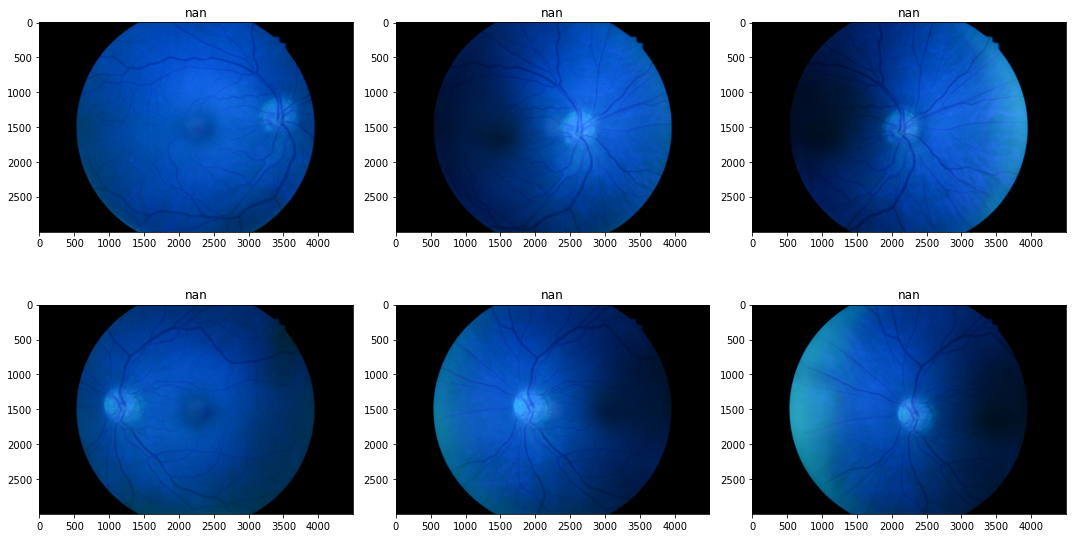

In [ ]:
def display_samples(df, columns=3, rows=2):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'{image_path}')
        
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(test_df)

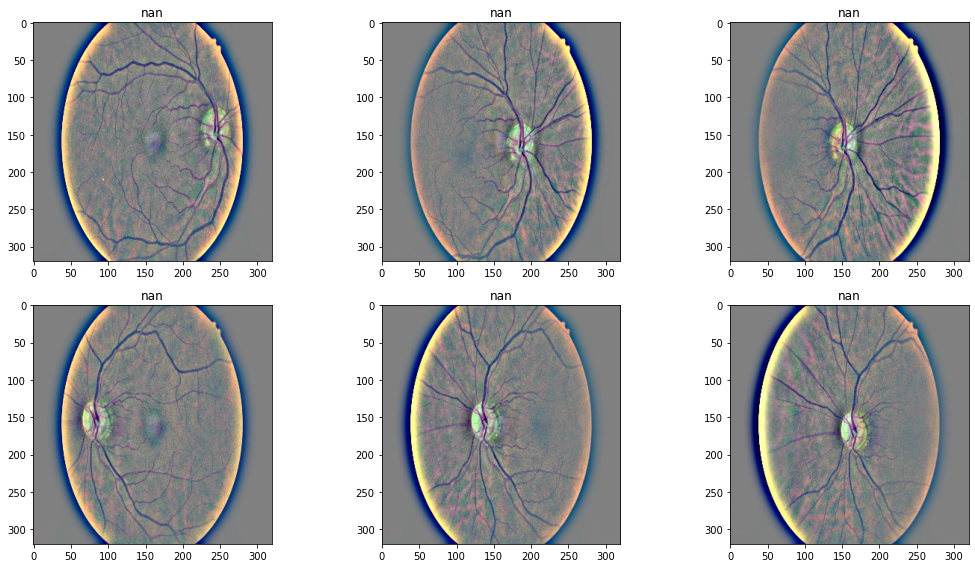

In [ ]:
def display_samples(df, columns=3, rows=2):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(test_df)

In [ ]:
for i, image_id in enumerate(tqdm_notebook(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'{image_id}',
        desired_size = im_size
    )

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/DR/model/drmodel.h5')

In [ ]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
print(test_df)
test_df.to_csv('/content/drive/MyDrive/DR/submission.csv',index=False)


                                         id_code  diagnosis
0  /content/drive/MyDrive/DR/valid/images001.jpg          0
1  /content/drive/MyDrive/DR/valid/images002.jpg          0
2  /content/drive/MyDrive/DR/valid/images003.jpg          0
3  /content/drive/MyDrive/DR/valid/images004.jpg          0
4  /content/drive/MyDrive/DR/valid/images005.jpg          0
5  /content/drive/MyDrive/DR/valid/images006.jpg          0
6  /content/drive/MyDrive/DR/valid/images007.jpg          0
